In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


In [2]:
import wandb

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
run = wandb.init(project="urlset-classification")

wandb: Currently logged in as: michellebonchieku99 (michellebonchieku99-usiu). Use `wandb login --relogin` to force relogin


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import io

In [6]:
# Read the file in binary mode
with open('/content/urlset.csv', 'rb') as file:
    raw_data = file.read()

# Decode the content manually with error handling
decoded_data = raw_data.decode('MacRoman', errors='replace')

# Use io.StringIO to read the decoded content as if it were a file
phishing = pd.read_csv(io.StringIO(decoded_data), on_bad_lines='skip')



<ipython-input-6-29f8e4e80172>:9: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing = pd.read_csv(io.StringIO(decoded_data), on_bad_lines='skip')


In [7]:
phishing.head()

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11.0,150.636364,152.272727,0.0,0.0,0.0,0.0,0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14.0,73.500000,72.642857,0.0,0.0,0.0,0.0,0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6.0,562.000000,590.666667,0.0,0.0,0.0,0.0,0,0.85964,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8.0,29.000000,24.125000,0.0,0.0,0.0,0.0,0,0.748971,1.0


In [8]:
phishing.shape

(96005, 14)

In [9]:
phishing.tail()

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
96000,xbox360.ign.com/objects/850/850402.html,339,1.0,1.0,2.0,142.5,141.000000,0.009009,0.009091,0.006536,0.006601,0.45098,0.846906,0.0
96001,games.teamxbox.com/xbox-360/1860/Dead-Space/,63029,1.0,0.0,3.0,114.0,128.333333,0.002899,0.002577,0.002907,0.002584,0.75,0.714623,0.0
96002,www.gamespot.com/xbox360/action/deadspace/,753,1.0,1.0,3.0,91.0,101.333333,0.000000,0.003106,0.000000,0.000000,0.111111,0.648571,0.0
96003,en.wikipedia.org/wiki/Dead_Space_(video_game),6,1.0,1.0,4.0,682.0,744.250000,0.033075,0.029412,0.030250,0.029145,0.809735,0.840323,0.0
96004,www.angelfire.com/goth/devilmaycrytonite/,2547,1.0,1.0,5.0,32.4,27.200000,0.022222,0.032680,0.017341,0.020408,0.636364,0.674157,0.0


In [10]:
phishing.isnull().sum()

domain            0
ranking          52
mld_res          70
mld.ps_res       81
card_rem         82
ratio_Rrem       82
ratio_Arem       82
jaccard_RR       83
jaccard_RA       84
jaccard_AR       85
jaccard_AA       86
jaccard_ARrd     86
jaccard_ARrem    88
label            92
dtype: int64

<Axes: >

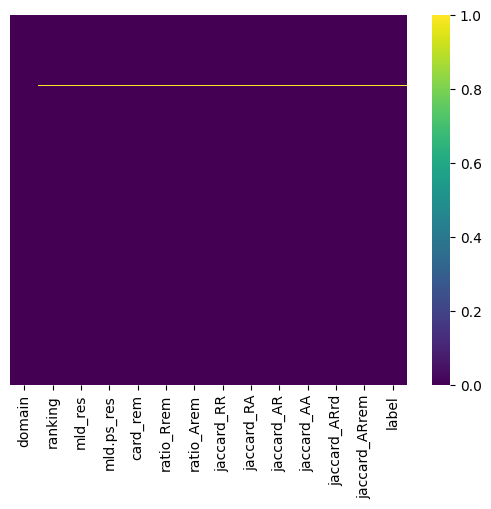

In [11]:
sns.heatmap(phishing.isnull(),yticklabels = False, cbar =True, cmap = 'viridis')

In [12]:
phishing = phishing.drop(columns=['domain'])

In [13]:
phishing_numeric = phishing.apply(pd.to_numeric, errors='coerce')

In [14]:
def fill_ranking(cols):
    ranking = cols[0]
    if pd.isnull(ranking):
        return 10000000
    else:
        return ranking

def fill_mld_res(cols):
    mld_res = cols[0]
    if pd.isnull(mld_res):
        return 0
    else:
        return mld_res

def fill_mld_ps_res(cols):
    mld_ps_res = cols[0]
    if pd.isnull(mld_ps_res):
        return 0
    else:
        return mld_ps_res

def fill_card_rem(cols):
    card_rem = cols[0]
    if pd.isnull(card_rem):
        return 6
    else:
        return card_rem

def fill_ratio_Rrem(cols):
    ratio_Rrem = cols[0]
    if pd.isnull(ratio_Rrem):
        return 152.674
    else:
        return ratio_Rrem

def fill_ratio_Arem(cols):
    ratio_Arem = cols[0]
    if pd.isnull(ratio_Arem):
        return 82
    else:
        return ratio_Arem

def fill_jaccard_RR(cols):
    jaccard_RR = cols[0]
    if pd.isnull(jaccard_RR):
        return 0
    else:
        return jaccard_RR

def fill_jaccard_RA(cols):
    jaccard_RA = cols[0]
    if pd.isnull(jaccard_RA):
        return 0
    else:
        return jaccard_RA

def fill_jaccard_AR(cols):
    jaccard_AR = cols[0]
    if pd.isnull(jaccard_AR):
        return 0
    else:
        return jaccard_AR

def fill_jaccard_AA(cols):
    jaccard_AA = cols[0]
    if pd.isnull(jaccard_AA):
        return 0
    else:
        return jaccard_AA

def fill_jaccard_ARrd(cols):
    jaccard_ARrd = cols[0]
    if pd.isnull(jaccard_ARrd):
        return 0
    else:
        return jaccard_ARrd

def fill_jaccard_ARrem(cols):
    jaccard_ARrem = cols[0]
    if pd.isnull(jaccard_ARrem):
        return 0.633333333
    else:
        return jaccard_ARrem

def fill_label(cols):
    label = cols[0]
    if pd.isnull(label):
        return 1
    else:
        return label

In [15]:
phishing['ranking'] = phishing[['ranking']].apply(fill_ranking, axis=1)
phishing['mld_res'] = phishing[['mld_res']].apply(fill_mld_res, axis=1)
phishing['mld.ps_res'] = phishing[['mld.ps_res']].apply(fill_mld_ps_res, axis=1)
phishing['card_rem'] = phishing[['card_rem']].apply(fill_card_rem, axis=1)
phishing['ratio_Rrem'] = phishing[['ratio_Rrem']].apply(fill_ratio_Rrem, axis=1)
phishing['ratio_Arem'] = phishing[['ratio_Arem']].apply(fill_ratio_Arem, axis=1)
phishing['jaccard_RR'] = phishing[['jaccard_RR']].apply(fill_jaccard_RR, axis=1)
phishing['jaccard_RA'] = phishing[['jaccard_RA']].apply(fill_jaccard_RA, axis=1)
phishing['jaccard_AR'] = phishing[['jaccard_AR']].apply(fill_jaccard_AR, axis=1)
phishing['jaccard_AA'] = phishing[['jaccard_AA']].apply(fill_jaccard_AA, axis=1)
phishing['jaccard_ARrd'] = phishing[['jaccard_ARrd']].apply(fill_jaccard_ARrd, axis=1)
phishing['jaccard_ARrem'] = phishing[['jaccard_ARrem']].apply(fill_jaccard_ARrem, axis=1)
phishing['label'] = phishing[['label']].apply(fill_label, axis=1)

<Axes: >

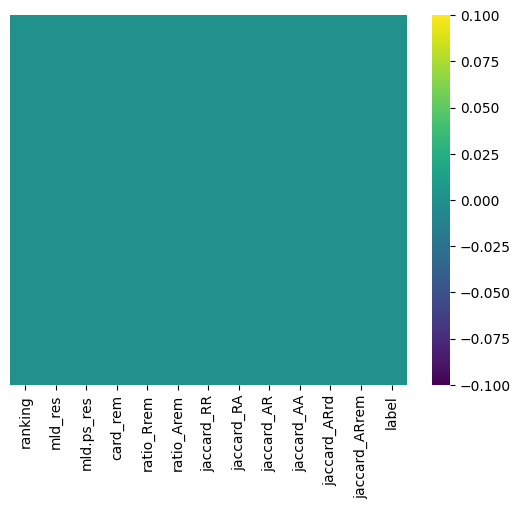

In [16]:
sns.heatmap(phishing.isnull(), yticklabels=False, cbar=True, cmap='viridis')

In [17]:
for col in phishing.columns:
    phishing[col] = pd.to_numeric(phishing[col], errors='coerce')

# Drop rows with any remaining non-numeric values
phishing.dropna(inplace=True)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = phishing.drop('label', axis=1)

In [20]:
y = phishing['label']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train.shape

(76777, 12)

In [23]:
X_train.head()

,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem
88985,10000000.0,0.0,0.0,4.0,198.500000,211.000000,0.0,0.0,0.0,0.0,0.0,0.800000
8248,10000000.0,0.0,0.0,1.0,197.000000,213.000000,0.0,0.0,0.0,0.0,0.0,0.722689
86922,313605.0,0.0,0.0,1.0,14.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.454545
15342,10000000.0,0.0,0.0,12.0,136.750000,134.583333,0.0,0.0,0.0,0.0,0.0,0.771491
45499,10000000.0,0.0,0.0,11.0,82.272727,78.090909,0.0,0.0,0.0,0.0,0.0,0.697786


In [24]:
X_test.shape

(19195, 12)

In [25]:
y_train.shape

(76777,)

In [26]:
y_train.head()

88985    0.0
8248     1.0
86922    0.0
15342    1.0
45499    1.0
Name: label, dtype: float64

In [27]:
y_test.shape

(19195,)

In [28]:
X_train.columns

Index(['ranking', 'mld_res', 'mld.ps_res', 'card_rem', 'ratio_Rrem',
       'ratio_Arem', 'jaccard_RR', 'jaccard_RA', 'jaccard_AR', 'jaccard_AA',
       'jaccard_ARrd', 'jaccard_ARrem'],
      dtype='object')

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
logmodel = LogisticRegression()

In [31]:
logmodel

LogisticRegression()

In [32]:
logmodel.fit(X_train, y_train)

LogisticRegression()

In [33]:
predictions = logmodel.predict(X_test)

In [34]:
predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [35]:
from sklearn.metrics import auc, accuracy_score, classification_report, log_loss, confusion_matrix

In [36]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      9605
         1.0       0.50      1.00      0.67      9590

    accuracy                           0.50     19195
   macro avg       0.25      0.50      0.33     19195
weighted avg       0.25      0.50      0.33     19195



Axes(0.125,0.11;0.62x0.77)


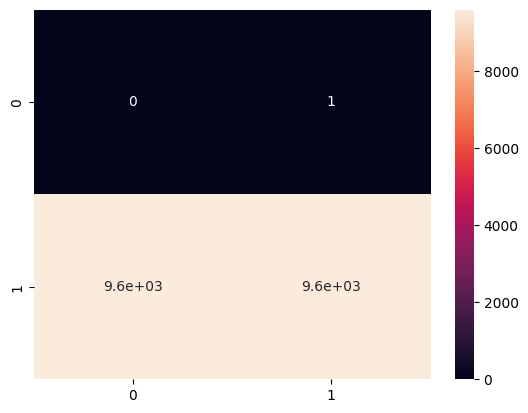

In [37]:
print(sns.heatmap(confusion_matrix(predictions, y_test), annot = True))

In [38]:
regression_accuracy= accuracy_score(y_test, predictions)

In [39]:
wandb.log({"accuracy": regression_accuracy})

In [40]:
print(f"Logistic Regression Accuracy: {regression_accuracy}")

Logistic Regression Accuracy: 0.4995571763480073


In [41]:
#DECISION TREE

In [42]:
# Read the file in binary mode
with open('/content/urlset.csv', 'rb') as file:
    raw_data = file.read()

# Decode the content manually with error handling
decoded_data = raw_data.decode('MacRoman', errors='replace')

# Use io.StringIO to read the decoded content as if it were a file
phishing = pd.read_csv(io.StringIO(decoded_data), on_bad_lines='skip')


<ipython-input-42-5348aab4fcad>:9: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing = pd.read_csv(io.StringIO(decoded_data), on_bad_lines='skip')


In [43]:
phishing

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18.0,107.611111,107.277778,0.000000,0.000000,0.000000,0.000000,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11.0,150.636364,152.272727,0.000000,0.000000,0.000000,0.000000,0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14.0,73.500000,72.642857,0.000000,0.000000,0.000000,0.000000,0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6.0,562.000000,590.666667,0.000000,0.000000,0.000000,0.000000,0,0.85964,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8.0,29.000000,24.125000,0.000000,0.000000,0.000000,0.000000,0,0.748971,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96000,xbox360.ign.com/objects/850/850402.html,339,1.0,1.0,2.0,142.500000,141.000000,0.009009,0.009091,0.006536,0.006601,0.45098,0.846906,0.0
96001,games.teamxbox.com/xbox-360/1860/Dead-Space/,63029,1.0,0.0,3.0,114.000000,128.333333,0.002899,0.002577,0.002907,0.002584,0.75,0.714623,0.0
96002,www.gamespot.com/xbox360/action/deadspace/,753,1.0,1.0,3.0,91.000000,101.333333,0.000000,0.003106,0.000000,0.000000,0.111111,0.648571,0.0
96003,en.wikipedia.org/wiki/Dead_Space_(video_game),6,1.0,1.0,4.0,682.000000,744.250000,0.033075,0.029412,0.030250,0.029145,0.809735,0.840323,0.0


In [44]:
from sklearn import tree

In [45]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)

In [46]:
clf

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [47]:
clf=clf.fit(X,y)

In [48]:
clf

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [49]:
import pydotplus

In [50]:
from IPython.display import Image

In [51]:
dot_data = tree.export_graphviz(clf, feature_names=X.columns, class_names=['non-phishing', 'phishing'], filled=True,  out_file=None)

In [52]:
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("decision_tree.png")

True

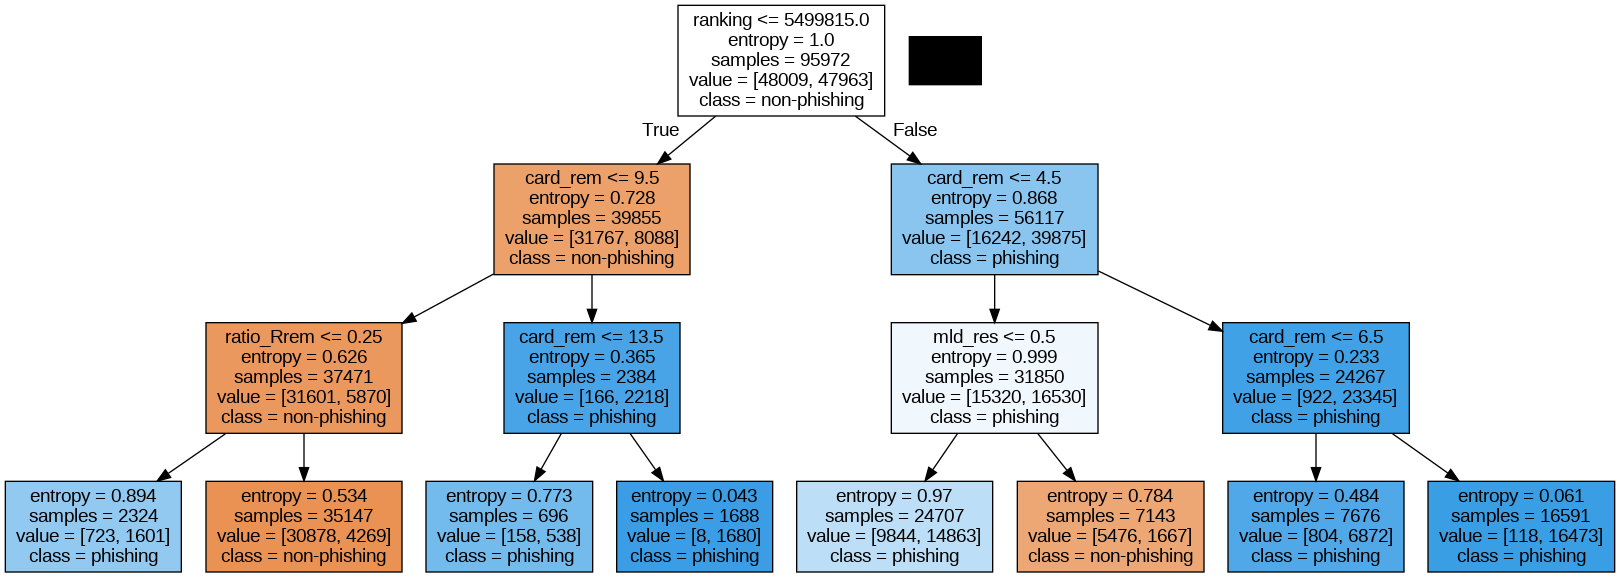

In [53]:
graph

Image(graph.create_png())

In [54]:
wandb.log({"decision_tree": wandb.Image("decision_tree.png")})

In [55]:
testData = [
    [630, 0, 0, 18.0, 107.611111, 107.277778, 0.0, 0.0, 0.0, 0.0, 0.8, 0.795729, 1],
    [10000000, 0, 0, 18.0, 107.611111, 107.277778, 0.0, 0.0, 0.0, 0.0, 0.8, 0.795729, 1],
    [1, 0, 0, 11.0, 150.636364, 152.272727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.768577, 1],
    [10000000, 0, 0, 14.0, 73.500000, 72.642857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.726582, 1],
    [46091, 0, 0, 6.0, 562.000000, 590.666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85964, 1]
]

In [56]:
testData

[[630,
  0,
  0,
  18.0,
  107.611111,
  107.277778,
  0.0,
  0.0,
  0.0,
  0.0,
  0.8,
  0.795729,
  1],
 [10000000,
  0,
  0,
  18.0,
  107.611111,
  107.277778,
  0.0,
  0.0,
  0.0,
  0.0,
  0.8,
  0.795729,
  1],
 [1, 0, 0, 11.0, 150.636364, 152.272727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.768577, 1],
 [10000000, 0, 0, 14.0, 73.5, 72.642857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.726582, 1],
 [46091, 0, 0, 6.0, 562.0, 590.666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85964, 1]]

In [57]:
X.columns

Index(['ranking', 'mld_res', 'mld.ps_res', 'card_rem', 'ratio_Rrem',
       'ratio_Arem', 'jaccard_RR', 'jaccard_RA', 'jaccard_AR', 'jaccard_AA',
       'jaccard_ARrd', 'jaccard_ARrem'],
      dtype='object')

In [58]:
columns_to_use = ['ranking','mld_res', 'mld.ps_res', 'card_rem', 'ratio_Rrem', 'ratio_Arem',
                  'jaccard_RR', 'jaccard_RA', 'jaccard_AR', 'jaccard_AA', 'jaccard_ARrd', 'jaccard_ARrem']

In [59]:
testData = pd.DataFrame(testData, columns = columns_to_use +  ['label'])

In [60]:
testData

,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,630,0,0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1
1,10000000,0,0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1
2,1,0,0,11.0,150.636364,152.272727,0.0,0.0,0.0,0.0,0.0,0.768577,1
3,10000000,0,0,14.0,73.500000,72.642857,0.0,0.0,0.0,0.0,0.0,0.726582,1
4,46091,0,0,6.0,562.000000,590.666667,0.0,0.0,0.0,0.0,0.0,0.859640,1


In [61]:
testY = testData['label']

In [62]:
testY

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [63]:
testX = testData.drop(['label'], axis=1)

In [64]:
testX

,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem
0,630,0,0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729
1,10000000,0,0,18.0,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729
2,1,0,0,11.0,150.636364,152.272727,0.0,0.0,0.0,0.0,0.0,0.768577
3,10000000,0,0,14.0,73.500000,72.642857,0.0,0.0,0.0,0.0,0.0,0.726582
4,46091,0,0,6.0,562.000000,590.666667,0.0,0.0,0.0,0.0,0.0,0.859640


In [65]:
predY = clf.predict(testX)

In [66]:
predY

array([1., 1., 1., 1., 0.])

In [67]:
predictions = pd.concat([testData.reset_index(drop=True), pd.Series(predY, name='Predicted Class')], axis=1)

In [68]:
accuracy = accuracy_score(testY, predY)

In [69]:
print(f'Accuracy on test data is {accuracy:.2f}')

Accuracy on test data is 0.80


In [70]:
wandb.log({"test_accuracy": accuracy})

In [71]:
maxDepths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [72]:
trainAcc = np.zeros(len(maxDepths))

In [73]:
trainAcc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [74]:
testAcc = np.zeros(len(maxDepths))

In [75]:
testAcc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [76]:
index = 0


for depth in maxDepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc[index] = accuracy_score(y_train, Y_predTrain)  # Training data accuracy
    testAcc[index] = accuracy_score(y_test, Y_predTest)     # Test data accuracy
    wandb.log({f"train_accuracy_depth_{depth}": trainAcc[index],
               f"test_accuracy_depth_{depth}": testAcc[index]})
    index += 1

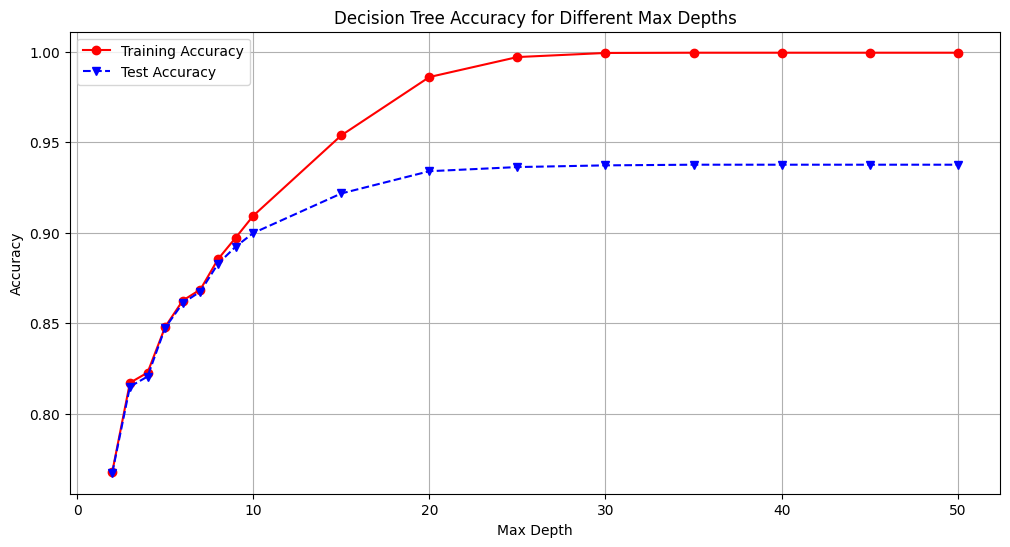

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(maxDepths, trainAcc, 'ro-', maxDepths, testAcc, 'bv--')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy for Different Max Depths')
plt.grid(True)
plt.show()

In [78]:
wandb.finish()

accuracy,▁
test_accuracy,▁
test_accuracy_depth_10,▁
test_accuracy_depth_15,▁
test_accuracy_depth_2,▁
test_accuracy_depth_20,▁
test_accuracy_depth_25,▁
test_accuracy_depth_3,▁
test_accuracy_depth_30,▁
test_accuracy_depth_35,▁
test_accuracy_depth_4,▁


**ANALYSIS ON OPTIMUM DEPTH**

In [79]:
testAcc.max()

0.93764001041938

The analysis of the optimum depth for the Decision Tree classifier aimed to identify the depth that yields the highest test accuracy on the dataset.
By evaluating a range of depths `maxDepths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]` and recording the test accuracy (testAcc) for each, the depth corresponding to the highest accuracy was determined using the `testAcc.max()` function.
**The wandb plot visually confirmed that the test accuracy peaked at depth 45 with a value of 0.9376, indicating that this depth provided the best performance. Thus, depth 45 was identified as the optimum depth for the Decision Tree, achieving the highest test accuracy compared to other depths.**

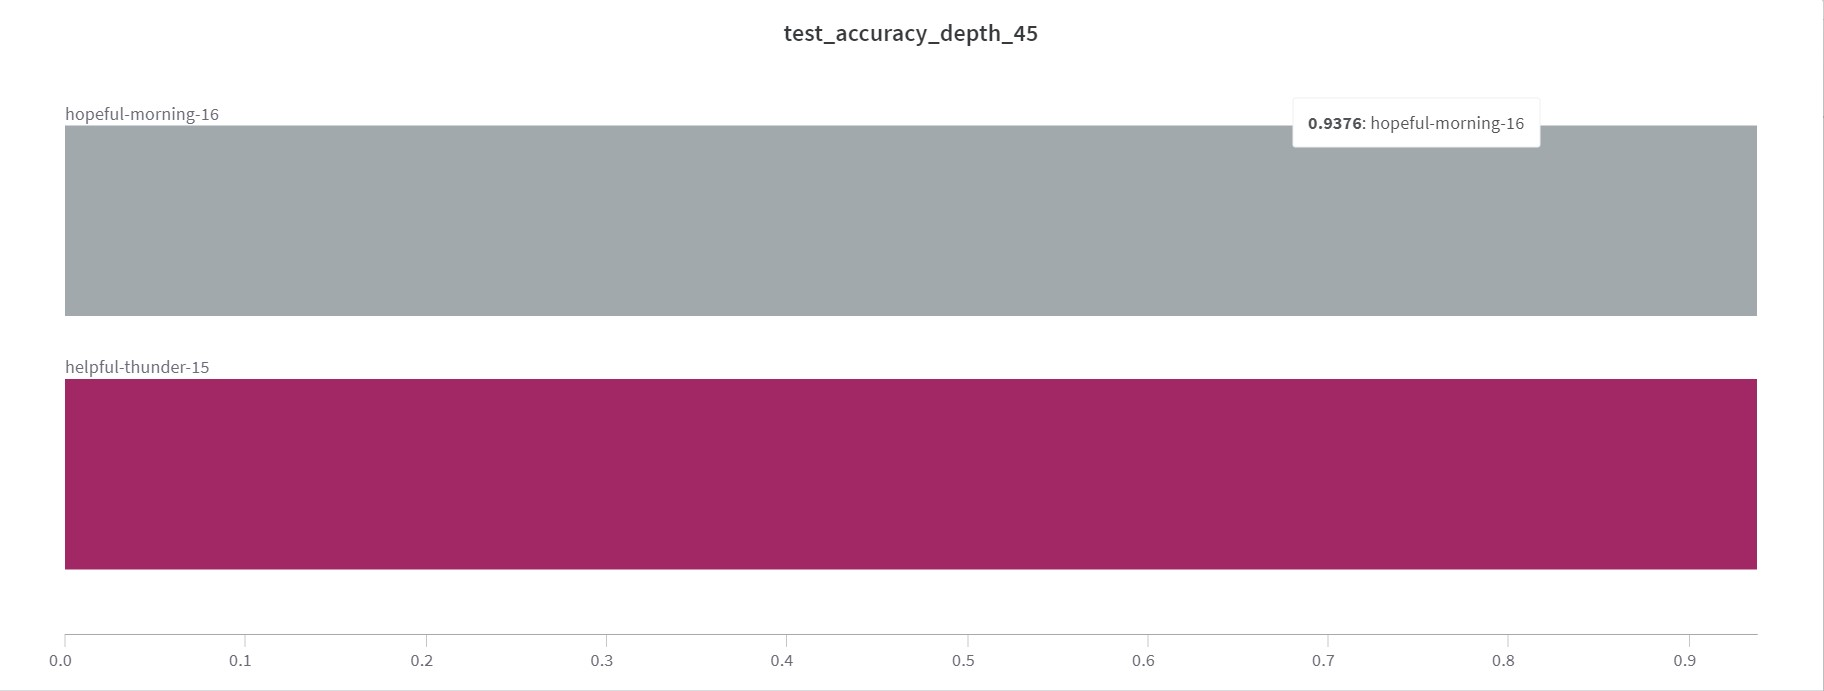